# Nasdaq Exploration Analysis

Main questions of focus are:
- zmeny za deň/rok
- rolling average
- distribúcia dát
- korelácia s ostatnými fondami/akciam
- seasonal decompose
- outlieri
- clusteing akcii

pozri či ti je na niečo adj

In [101]:
import sklearn.cluster
import sklearn.mixture
import sklearn.preprocessing
import sklearn.pipeline

import matplotlib.pyplot as plt
import matplotlib
import seaborn
import pandas
import numpy
import math
import os

import loader

# settings for seaborn plot
seaborn.set_theme()
seaborn.set(rc={'figure.figsize':(12, 8)})

### Loading data
The data is relatively big only picking small timeframe.

In [2]:
period_start = pandas.to_datetime("2018-01-01" ,format= '%Y-%m-%d')
period_end = pandas.to_datetime("2019-01-01" ,format= '%Y-%m-%d')

stocks = loader.get_period(period_start, period_end)
selected_symbols = list(stocks.keys())
print(f"Number of selected stocks: {len(selected_symbols)}")
stocks[selected_symbols[0]].head()

Number of selected stocks: 1675


,Open,High,Low,Close,Adj Close,Volume,TimeStamp
3637,23.170000,23.930000,23.170000,23.420000,23.420000,430100,2018-01-02
3638,23.540001,24.360001,23.410000,24.110001,24.110001,570300,2018-01-03
3639,24.290001,24.879999,24.160000,24.740000,24.740000,684000,2018-01-04
3640,24.930000,25.059999,24.549999,25.010000,25.010000,643300,2018-01-05
3641,25.000000,25.110001,23.790001,23.900000,23.900000,451800,2018-01-08


It is rather hard to cluster stocks based on the opening and closing prices. Lets compute various statistical indicators which will be easier to handle for the clustering algorithm. We will use:
- Average return: average change in the closing price
- Return variance: variange of the change in the closing price

In [3]:
stats = {}
for sym in selected_symbols:
    # return
    daily_returns = stocks[sym]['Close'].pct_change()
    annual_mean_returns = daily_returns.mean() * loader.NOF_TRADING_DAYS

    # variance
    annual_return_variance = daily_returns.var() * loader.NOF_TRADING_DAYS
    
    stats[sym] = [annual_mean_returns, annual_return_variance]

stock_stats = pandas.DataFrame.from_dict(
    stats,
    orient='index',
    columns=['Return', 'Variance']
)
stock_stats

,Return,Variance
ATSG,0.046082,0.146847
ZEUS,-0.363237,0.169284
BNED,-0.576498,0.329103
DDS,0.107165,0.225054
NSEC,-0.158602,0.142223
...,...,...
STAY,-0.174228,0.068540
OBSV,0.517637,0.535301
WAL,-0.332497,0.069393
AN,-0.351832,0.072036


Industry something

In [99]:
screener = pandas.read_csv("nasdaq_screener.csv")
# nan != nan
mapping = {s:[] for s in set(screener['Sector']) if s == s}

for sym in stock_stats.index.to_list():
    sector = screener[screener['Symbol'] == sym]['Sector'].values
    
    if sector and isinstance(sector[0], str): 
        mapping[sector[0]].append(sym)

sector_names = mapping.keys()
sector_names

/tmp/ipykernel_117506/2708939665.py:8: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if sector and isinstance(sector[0], str):


dict_keys(['Miscellaneous', 'Real Estate', 'Telecommunications', 'Utilities', 'Health Care', 'Industrials', 'Consumer Staples', 'Energy', 'Consumer Discretionary', 'Basic Materials', 'Finance', 'Technology'])

<Figure size 1200x800 with 0 Axes>

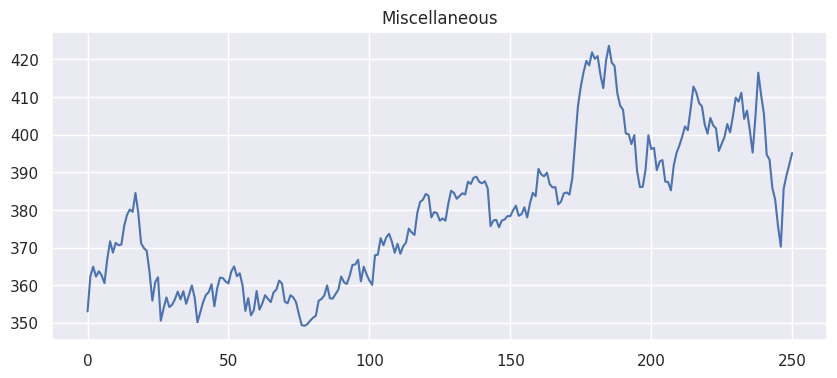

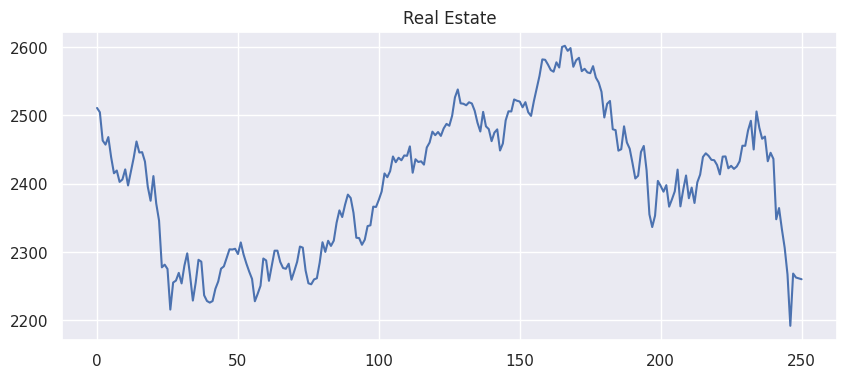

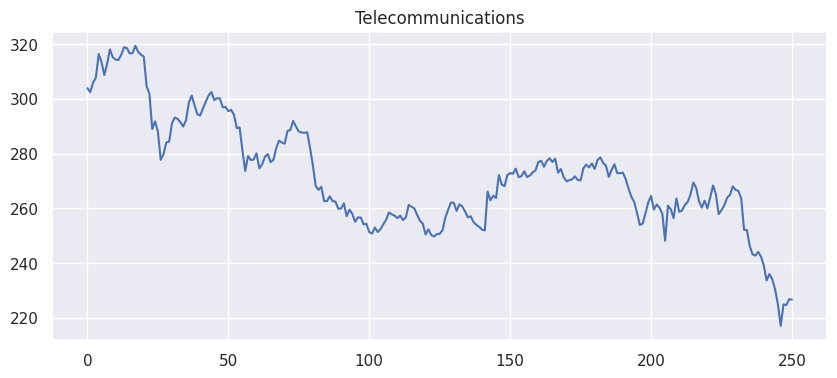

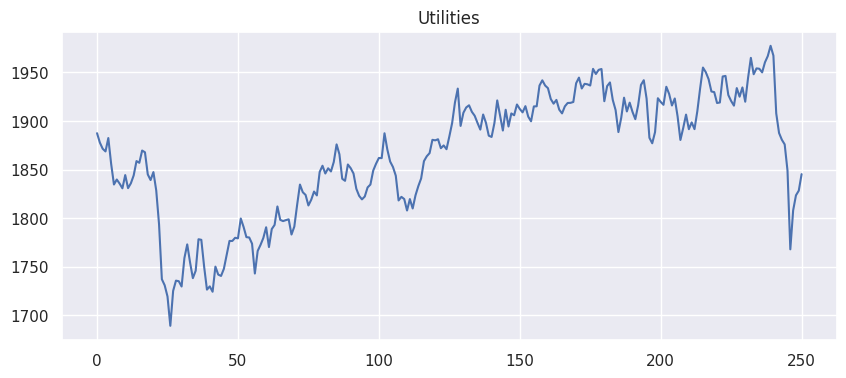

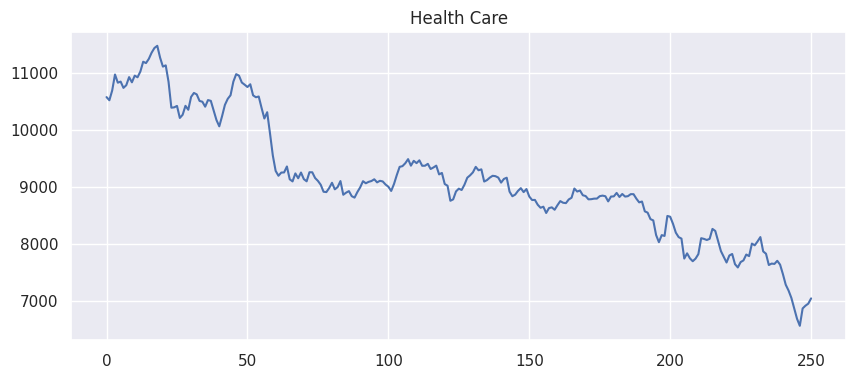

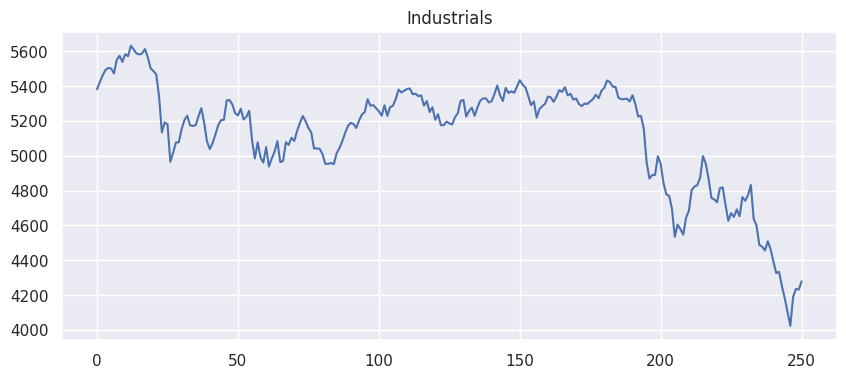

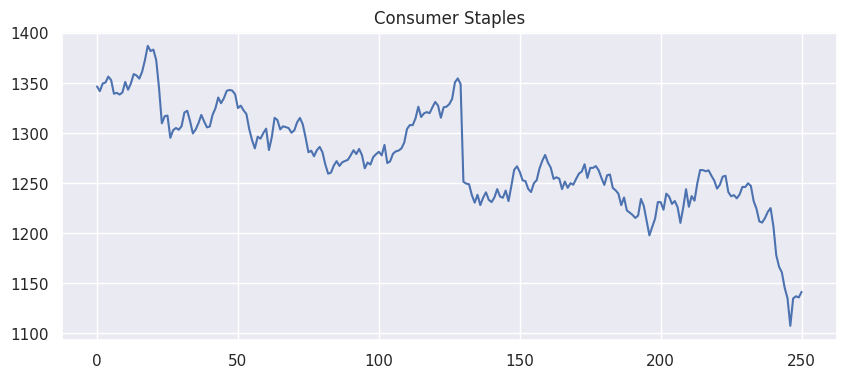

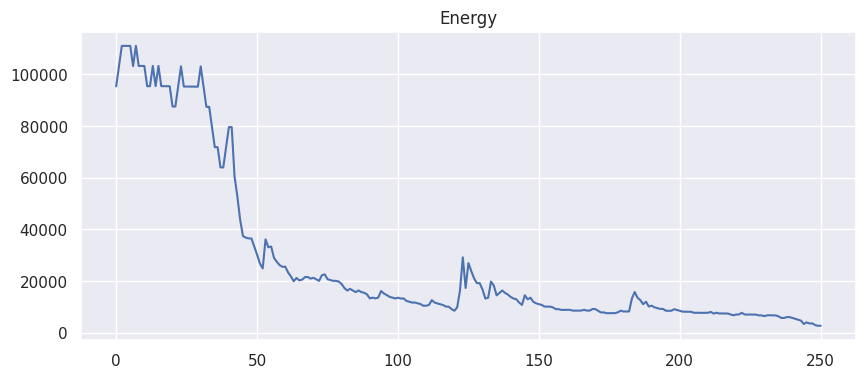

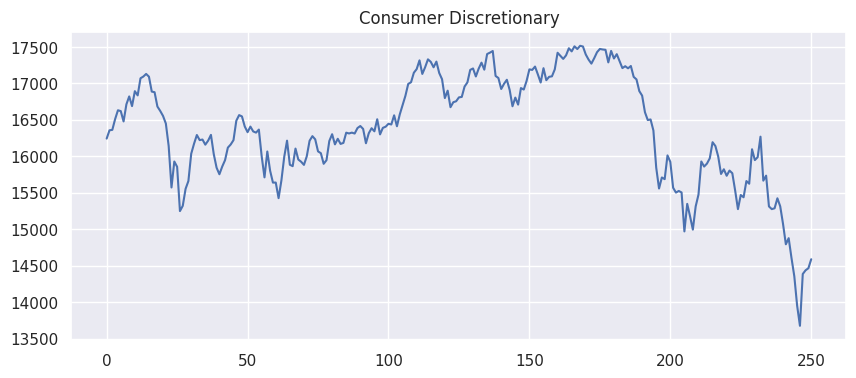

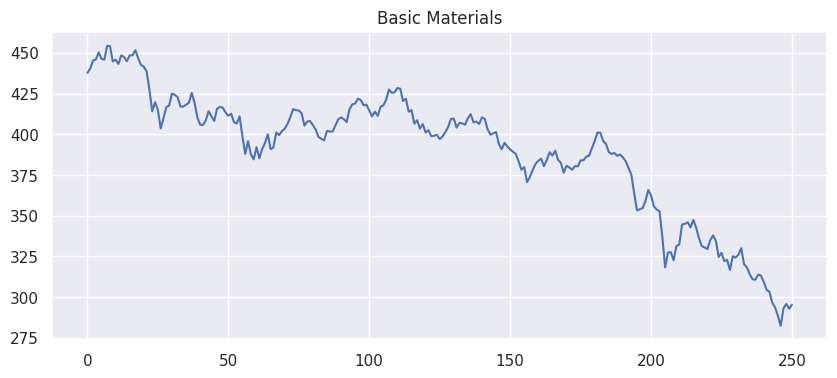

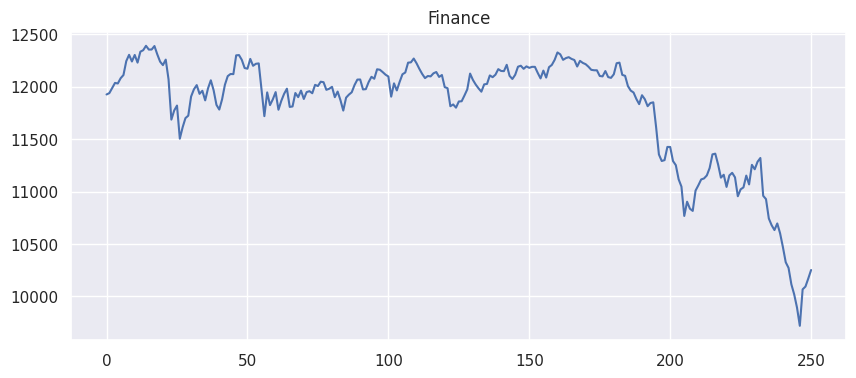

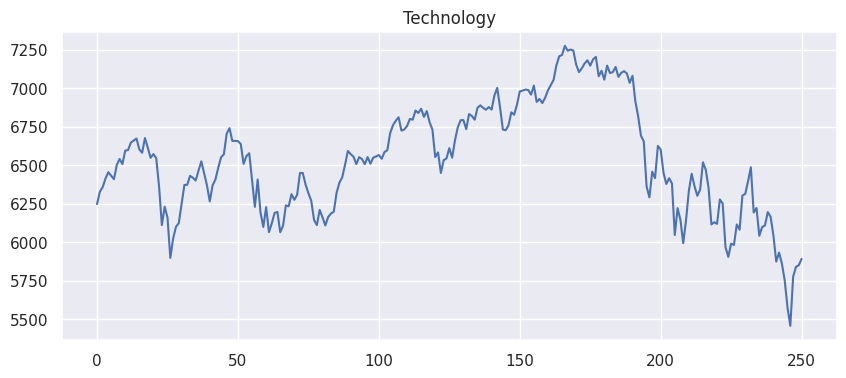

In [116]:
for i, sec in enumerate(sector_names):
    industry_dict = {s:stocks[s]['Close'].tolist() for s in mapping[sec]}
    industry = pandas.DataFrame.from_dict(industry_dict)


    plt.figure(i)
    fig, ax = plt.subplots(figsize=(10, 4))
    fig = seaborn.lineplot(data=industry.sum(axis=1))
    fig.set_title(sec)
    

Kmeans algorithm is relative vounerable to outliers therefor I am goint to remove quantile ...

/home/benb/.local/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


Text(0.5, 1.0, 'Technology')

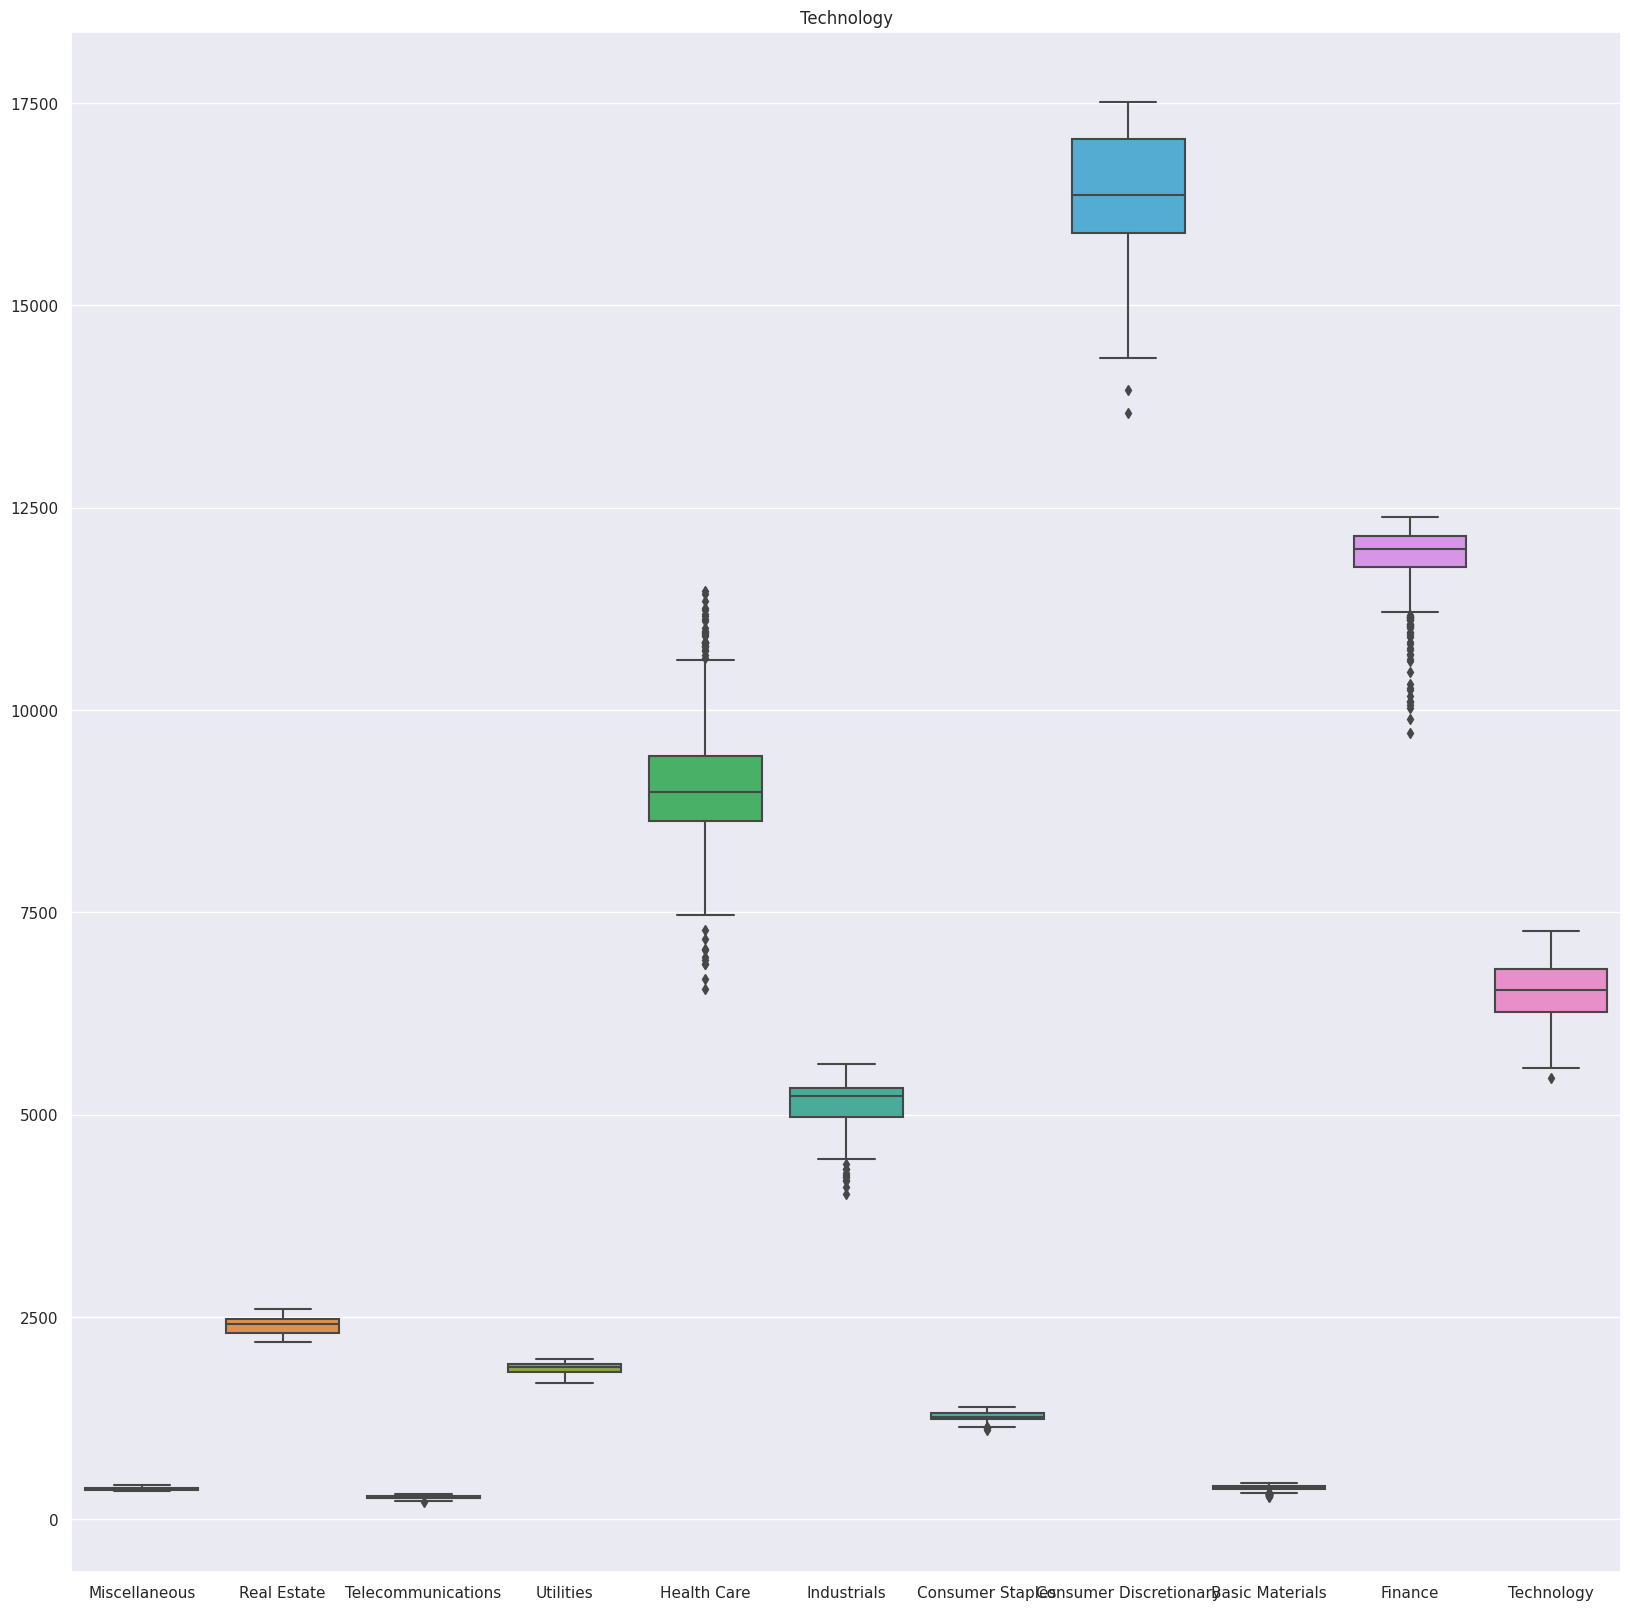

In [133]:
industry_sum = pandas.DataFrame()
for i, sec in enumerate(sector_names):
    industry_dict = {s:stocks[s]['Close'].tolist() for s in mapping[sec]}
    industry = pandas.DataFrame.from_dict(industry_dict)
    industry_sum[sec] = industry.sum(axis=1)


industry_sum = industry_sum.drop(columns=['Energy'])
fig, ax = plt.subplots(figsize=(20, 20))
fig = seaborn.boxplot(data=industry_sum)
fig.set_title(sec)


In [107]:
print(f"Number of stocks before removing outliers: {len(stock_stats)}")

q_return_high = stock_stats['Return'].quantile(0.99)
q_return_low = stock_stats['Return'].quantile(0.01)
stock_stats = stock_stats[(stock_stats["Return"] < q_return_high) & (stock_stats["Return"] > q_return_low)]

q_variance = stock_stats['Variance'].quantile(0.99)
stock_stats = stock_stats[stock_stats["Variance"] < q_variance]

print(f"Number of stocks after removing outliers: {len(stock_stats)}")

Number of stocks before removing outliers: 1624
Number of stocks after removing outliers: 1574


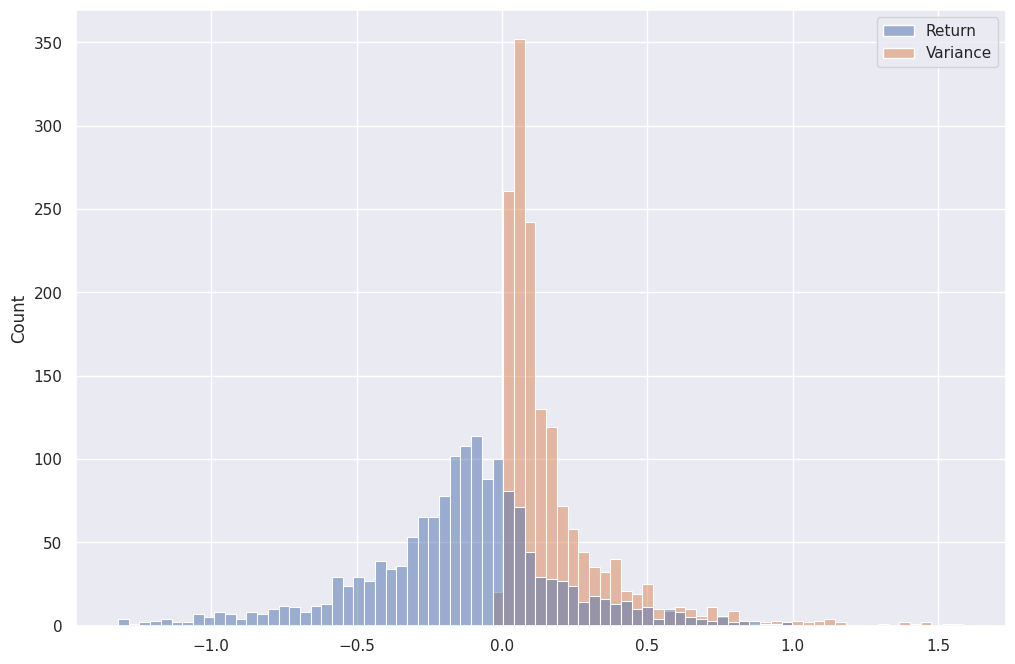

In [108]:
histogrtam = seaborn.histplot(data=stock_stats)

### K-Means Algorithm

Text(0, 0.5, 'Sum of squared distances')

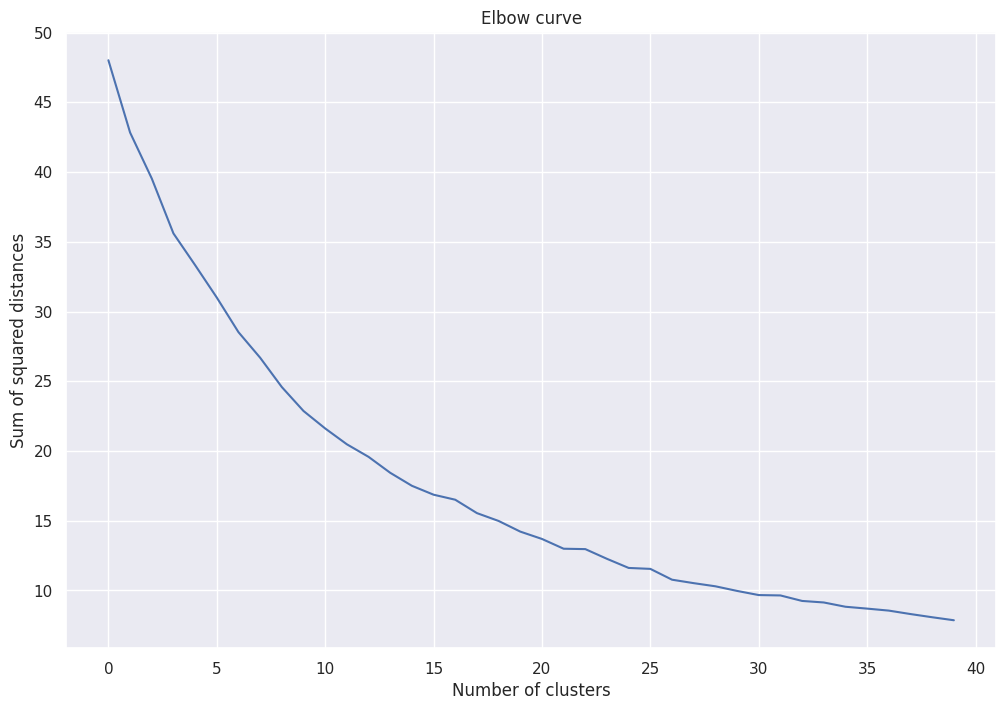

In [29]:
X = stock_stats[['Return', 'Variance']]
SSE  = []

for i in range(10, 50):
    kmeans = sklearn.cluster.KMeans(n_clusters=i)
    kmeans.fit(X)
    SSE.append(kmeans.inertia_)

elbow_curve = seaborn.lineplot(SSE)
elbow_curve.set_title("Elbow curve")
elbow_curve.set_xlabel("Number of clusters")
elbow_curve.set_ylabel("Sum of squared distances")

Number of stocks in cluster 0: 858
Number of stocks in cluster 1: 121
Number of stocks in cluster 2: 145
Number of stocks in cluster 3: 469
Number of stocks in cluster 4: 31


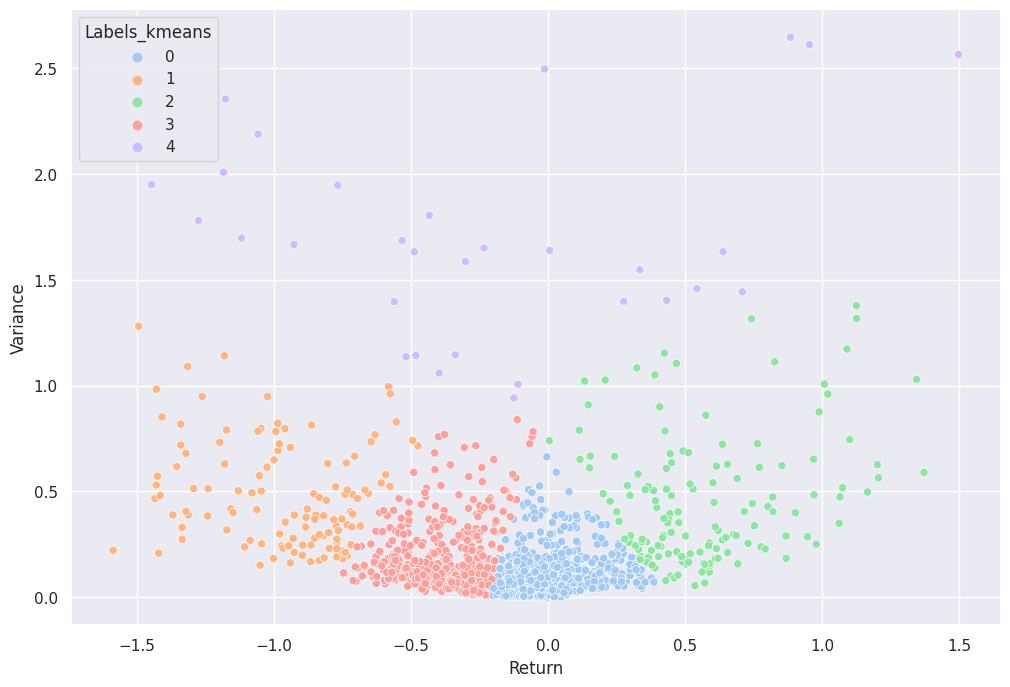

In [35]:
n_clusters = 5
kmeans = sklearn.cluster.KMeans(n_clusters=n_clusters)
kmeans.fit(X)
stock_stats['Labels_kmeans'] = kmeans.predict(X)

for c in range(n_clusters):
    print(f"Number of stocks in cluster {c}: {len(stock_stats[stock_stats['Labels_kmeans'] == c])}")

clusterin_plot = seaborn.scatterplot(data=stock_stats, x='Return', y='Variance', hue='Labels_kmeans', palette='pastel')

Number of stocks in cluster 0: 286
Number of stocks in cluster 1: 337
Number of stocks in cluster 2: 94
Number of stocks in cluster 3: 88
Number of stocks in cluster 4: 19
Number of stocks in cluster 5: 176
Number of stocks in cluster 6: 458
Number of stocks in cluster 7: 166


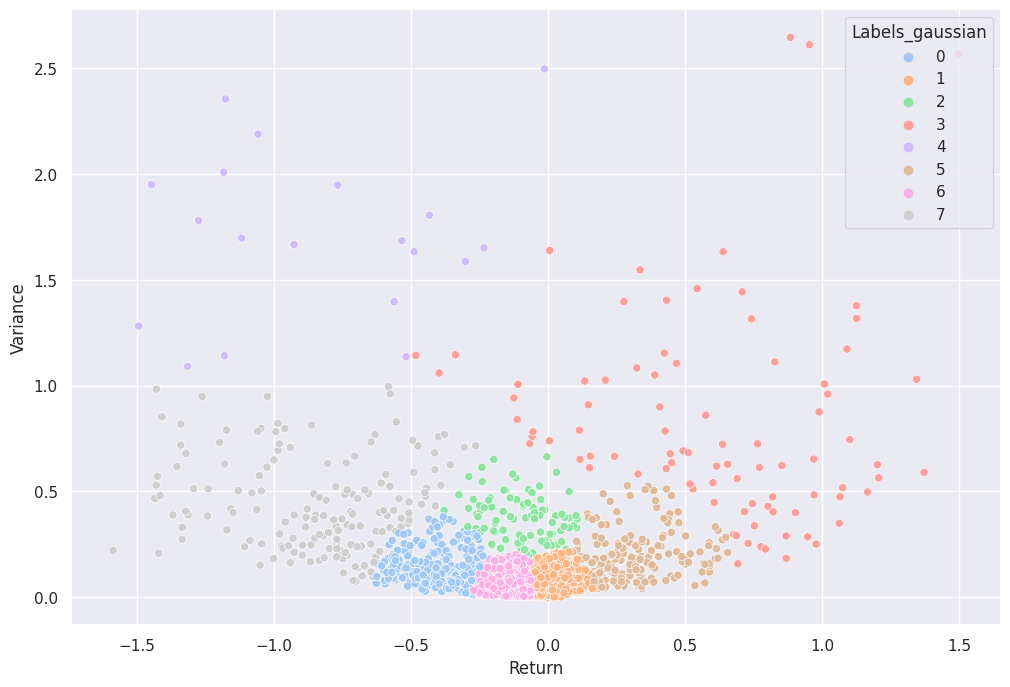

In [45]:
n_components = 8
gaussian_mixture = sklearn.mixture.GaussianMixture(n_components=n_components, covariance_type='spherical')
gaussian_mixture.fit(X)
stock_stats['Labels_gaussian'] = gaussian_mixture.predict(X)

for c in range(n_components):
    print(f"Number of stocks in cluster {c}: {len(stock_stats[stock_stats['Labels_gaussian'] == c])}")

clusterin_plot = seaborn.scatterplot(data=stock_stats, x='Return', y='Variance', hue='Labels_gaussian', palette='pastel')

### Covariance matrix

### Seasonal Descompose

shrpe ratio
stupajuci rozptyl

In [65]:
screener = pandas.read_csv("nasdaq_screener.csv")
screener[screener['Symbol'] == 'AA']['Sector'].iloc[0]

'Industrials'